In [32]:
import dataset_creation as dsc
import attention_helpers as attention
import tensorflow as tf
from keras.layers.preprocessing.text_vectorization import TextVectorization
from PIL import Image
import numpy as np
import pandas as pd
from typing import Sequence


In [33]:
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.scorecam import Scorecam
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

In [34]:
train_64_aug = pd.read_pickle('train_64_aug.pkl')
test_64_aug = pd.read_pickle('test_64_aug.pkl')

In [ ]:
lstm = tf.keras.models.load_model('lstm_aug_64_emb32')

In [36]:
encoder = tf.keras.layers.TextVectorization(standardize=None)
encoder.adapt(train_64_aug.Chunk)

chunk_len, n_classes = (len(train_64_aug.Chunk[0].split(" ")), len(train_64_aug.Author.unique()))

In [37]:
lstm_embedder = tf.keras.Sequential(
    [
        tf.keras.layers.Embedding(
            input_dim=len(encoder.get_vocabulary()),
            output_dim=32,
        ),
    ]
)
lstm_embedder.layers[0].set_weights(lstm.layers[0].get_weights())

In [38]:
# Strip off the embedding layer and manually use the trained embedder to provide
# model inputs from the chunks because tf_keras_vis needs a float input vector
# to mess around with

lstm_stripped = tf.keras.Sequential(
    lstm.layers[1:]
)

lstm_stripped.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"],
)



In [39]:
# all standard tf_keras_vis stuff
# https://keisen.github.io/tf-keras-vis-docs/examples/attentions.html#Vanilla-Saliency

def vanilla_saliency(
    m: tf.keras.Model,
    X: list,
    y: list,
    ss: int=0,
    sn: float=0.2
    ) -> Sequence:

    score = CategoricalScore(y)
    saliency = Saliency(
        m,
        model_modifier=ReplaceToLinear(),
        clone=True
    )

    return saliency(
        score,
        np.asarray(X),                     
        smooth_samples=ss,
        smooth_noise=sn
    )

In [40]:
def gradcam(model: tf.keras.Model, X: Sequence, y: Sequence) -> Sequence:
    score = CategoricalScore(y)
    # Create GradCAM object
    gradcam = GradcamPlusPlus(model,
                          model_modifier=ReplaceToLinear(),
                          clone=True)
    # Generate heatmap with GradCAM
    return gradcam(score, np.asarray(X))

In [41]:
def scorecam(model: tf.keras.Model, X: Sequence, y: Sequence) -> Sequence:
    score = CategoricalScore(y)
    # Create ScoreCAM object
    scorecam = Scorecam(model)
    # Generate heatmap with ScoreCAM this searches backwards from the given
    # index to find the last convolutional layer
    return scorecam(score, np.asarray(X), penultimate_layer=-1)

In [42]:
df_filt = test_64_aug[:32].reset_index(drop=True)

X = lstm_embedder(encoder(df_filt.Chunk))
y = df_filt.Factor.tolist()
titles = df_filt.apply(lambda r: f"{r.Author} {r.Bookref}",axis=1)

In [43]:
# skanky way to force the model to compile to the right shape
_ =  lstm_stripped.predict(X)

1/1 [==============================] - 2s 2s/step


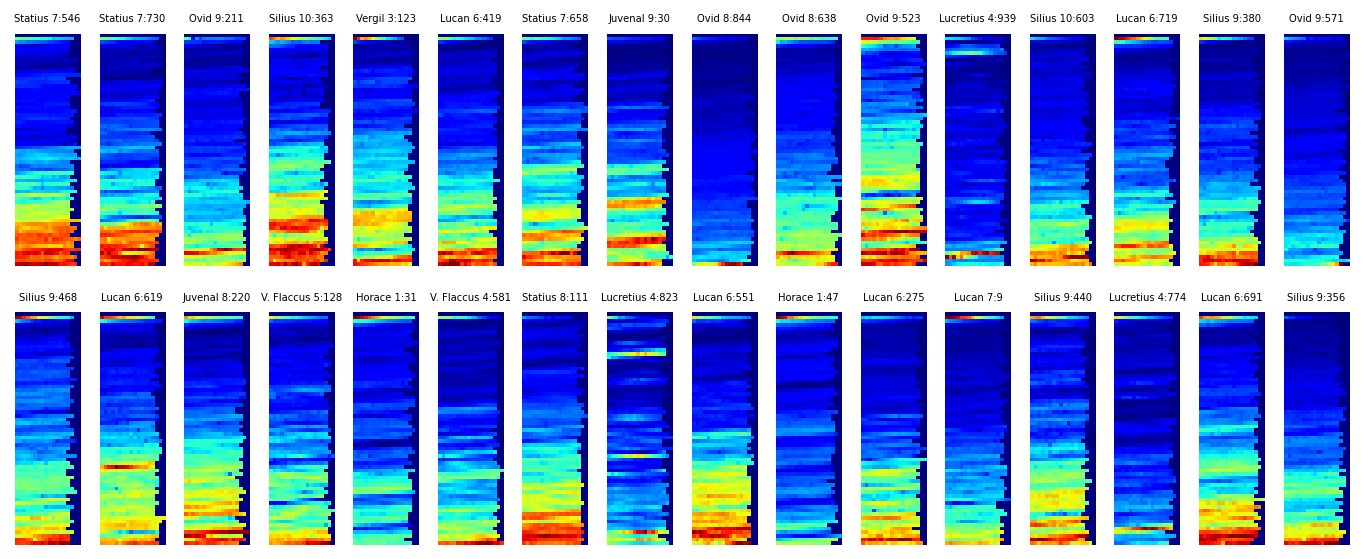

In [44]:
vs = attention.split_pad_many(df_filt.Chunk, vanilla_saliency(lstm_stripped, X, y))
attention.draw_thumbnails(vs, titles, h=4.7, show_idx=False)

In [45]:
# load saved CNN model and embedder

cnn_embedder = tf.keras.models.load_model('cnn_embedder_32')
cnn = tf.keras.models.load_model('cnn_aug_64_emb32')


In [46]:
# Build a new model with the same config that starts with the first conv layer,
# because tf_keras_vis needs a float input vector to mess around with

cnn_strip = tf.keras.Sequential([
    # previously had flatten, embed, reshape here...
    tf.keras.layers.Conv2D(24, kernel_size=(4,2), activation='relu', padding='same', name='conv1'),
    tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2,2)),
    tf.keras.layers.Conv2D(48, kernel_size=(4,2), activation='relu', padding='same', name='conv2'),
    tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, name='dense1'),
    tf.keras.layers.Dense(64, name='dense2'),
    tf.keras.layers.Dense(n_classes, activation='softmax', name='classify')
])

cnn_strip.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"],
)

cnn_strip.build((None,64,20,32))

# Now copy the layer weights from the saved model

for s in 'conv1 conv2 dense1 dense2 classify'.split():
    cnn_strip.get_layer(s).set_weights(cnn.get_layer(s).get_weights())

In [47]:
def chunk_to_ndarray(chunk: str, enc: TextVectorization) -> np.ndarray:
    '''
    Take a chunk of string tokens, and an encoder, and return an np.ndarray of
    n_lines x 20, padded left with [0,0] and right with as many 0s as needed to
    reach 20. ndarray is a 'native' type to convert to a tf tensor.
    '''
    encoded = enc(chunk)
    idx_ary = attention.eol_indices(chunk)
    lines = [encoded[idx_ary[i]:idx_ary[i+1]] for i in range(len(idx_ary)-2)]
    # build an array of zeroes
    padded = np.zeros((len(lines), 20),dtype=int)
    # then overwrite with the tokens, untouched 0s become padding
    for i, row in enumerate(lines):
        padded[i, 2:(len(row)+2)] = row 
    return padded

In [48]:
def prep_for_cnn(df, embedder, encoder) -> tuple[Sequence,Sequence,Sequence]:
    X = [embedder(chunk_to_ndarray(x,encoder)) for x in df.Chunk.tolist()]
    y = df.Factor.tolist()
    titles = df.apply(lambda r: f"{r.Author} {r.Bookref}",axis=1)
    return X, y, titles

In [49]:
# get a little subset of the test data

shov = test_64_aug[test_64_aug.Author.isin(['Silius','Horace','Ovid','Vergil'])].reset_index(drop=True)
shov = shov.groupby('Author').head(8).sort_values(['Author','Bookref']).reset_index(drop=True)
X = [cnn_embedder(chunk_to_ndarray(x,encoder)) for x in shov.Chunk.tolist()]
y = shov.Factor.tolist()
titles = shov.apply(lambda r: f"{r.Author} {r.Bookref}",axis=1)

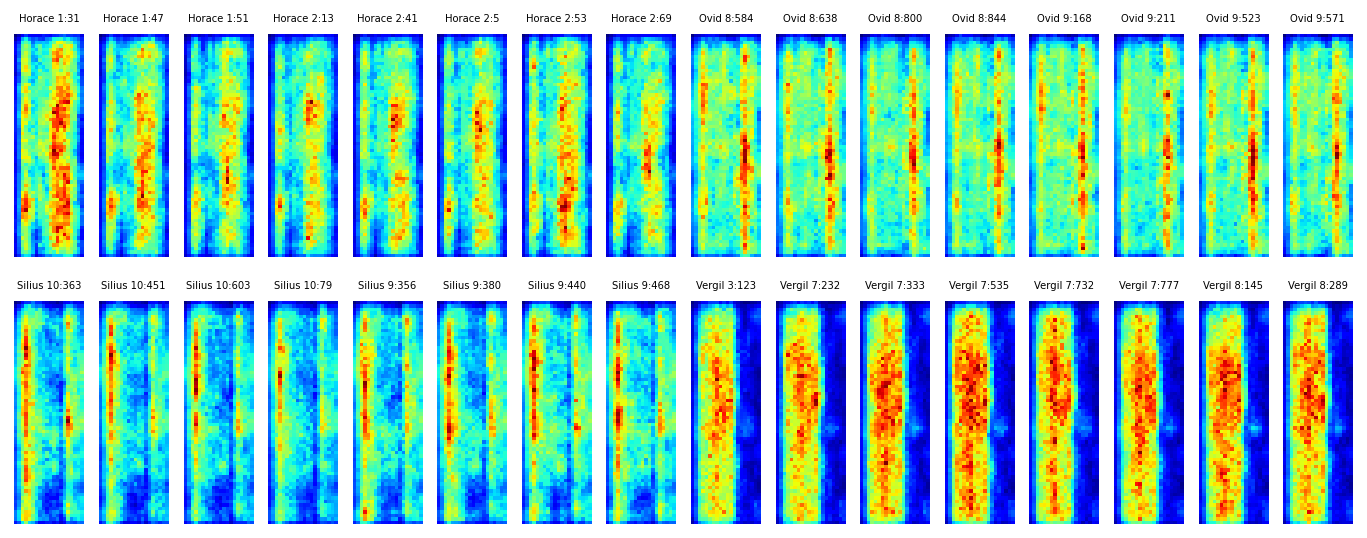

In [50]:
vscnn = vanilla_saliency(cnn_strip, X, y, ss=30, sn=0.1)
attention.draw_thumbnails(vscnn[:32], titles[:32], h=4.5, show_idx=False)

48/48 [==============================] - 0s 5ms/step


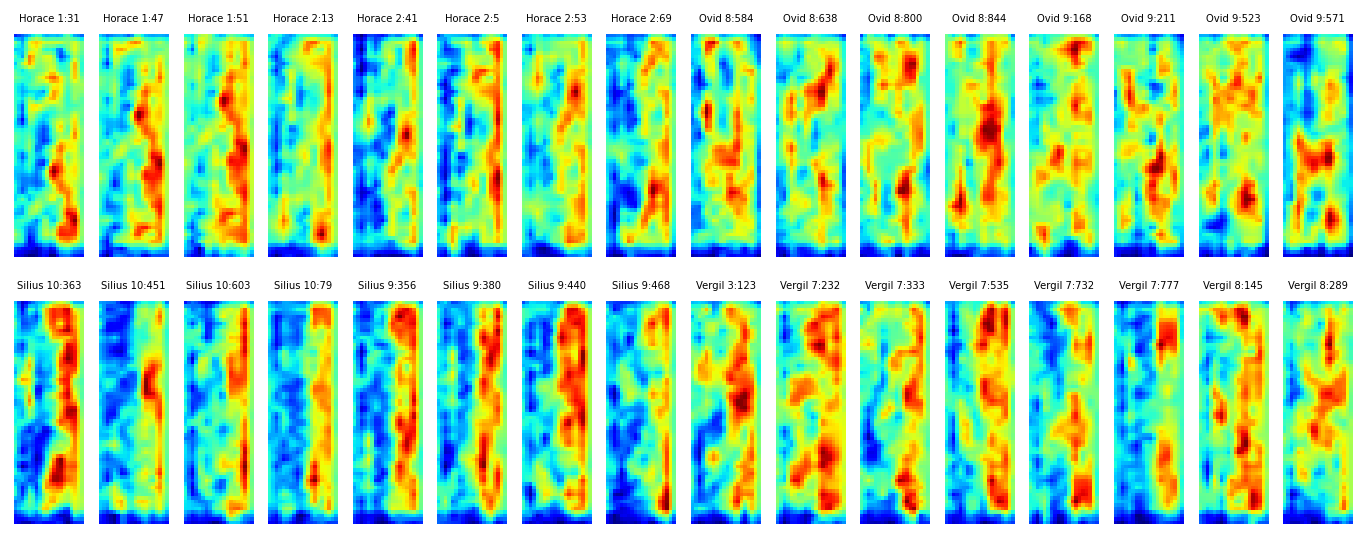

In [51]:
attention.draw_thumbnails(scorecam(cnn_strip, X, y), titles, show_idx=False, h=4.5)

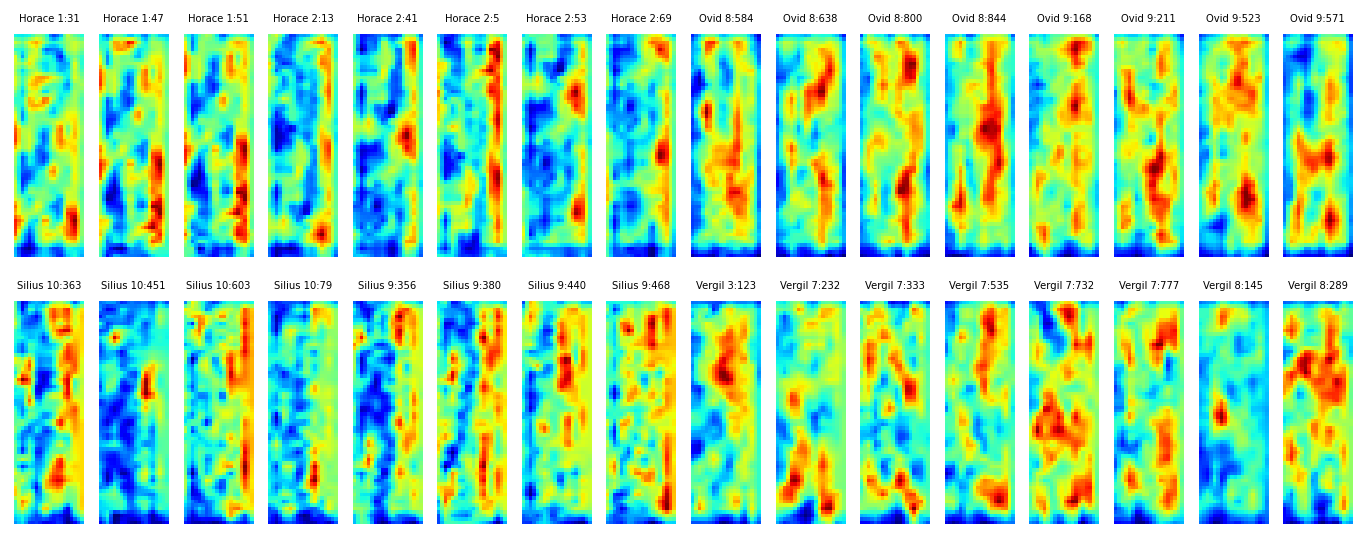

In [52]:
attention.draw_thumbnails(gradcam(cnn_strip, X, y), titles, show_idx=False, h=4.5)

# Detailed Attention Maps

## General Approach

Basically we typeset the text of the chunk, along with a regularised (my metron) phonetic transcription using the MQDQ software I've been using for various other projects. On top of that we alpha blend the heatmap we get from tf-keras-vis.

From here on we need to re-create the datasets from scratch, which is slow, because the raw BeautifulSoup data is needed from the MQDQ XML files, and that stuff doesn't serialise (it's oo recursive)

In [53]:
corpus = {
    'juv_sat' : (['corpus/IVV-satu-no-ojf.xml'], 'Juvenal', 'Satires', None),
    'luc_phar' : (['corpus/LVCAN-phar.xml'], 'Lucan', 'Pharsalia', None),
    'ov_met' : (['corpus/OV-meta.xml'],'Ovid', 'Metamorphoses', None),
    'sil_puni' : (['corpus/SIL-puni.xml'], 'Silius', 'Punica', None),
    'stat_theb' : (['corpus/STAT-theb.xml'], 'Statius', 'Thebaid', None),
    'flac_argo' : (['corpus/VAL_FL-argo.xml'], 'V. Flaccus', 'Argonautica', None),
    'verg_aen' : (['corpus/VERG-aene.xml'], 'Vergil', 'Aeneid', None),
    'lucr_dnr' : (['corpus/LVCR-rena.xml'], 'Lucretius', 'De Rerum Natura', None),
    'verg_geo' : (['corpus/VERG-geor.xml'], 'Vergil', 'Georgics', None),
    'hor_sat' : (['corpus/HOR-sat1.xml', 'corpus/HOR-sat2.xml'], 'Horace', 'Satires', None)
}

_, chunks_64 = dsc.chunked_dataset(
    chunk=64,
    step=64,
    corpus=corpus,
    mapper=dsc.lines_to_aug_sylstream,
    return_raw=True
)

_, chunks_32 = dsc.chunked_dataset(
    chunk=32,
    step=32,
    corpus=corpus,
    mapper=dsc.lines_to_aug_sylstream,
    return_raw=True
)

12/02/2022 16:51:41 [DEBUG] > Creating Babbler juv_sat
12/02/2022 16:51:48 [DEBUG] > Holding out 383 lines from 3832
12/02/2022 16:51:48 [DEBUG] > Got 52 training chunks and 5 holdout chunks.
12/02/2022 16:51:48 [DEBUG] > Creating Babbler luc_phar
12/02/2022 16:52:10 [DEBUG] > Holding out 806 lines from 8060
12/02/2022 16:52:10 [DEBUG] > Got 112 training chunks and 12 holdout chunks.
12/02/2022 16:52:10 [DEBUG] > Creating Babbler ov_met
12/02/2022 16:52:37 [DEBUG] > Holding out 1200 lines from 12009
12/02/2022 16:52:38 [DEBUG] > Got 168 training chunks and 18 holdout chunks.
12/02/2022 16:52:38 [DEBUG] > Creating Babbler sil_puni
12/02/2022 16:53:02 [DEBUG] > Holding out 1220 lines from 12200
12/02/2022 16:53:02 [DEBUG] > Got 171 training chunks and 19 holdout chunks.
12/02/2022 16:53:02 [DEBUG] > Creating Babbler stat_theb
12/02/2022 16:53:26 [DEBUG] > Holding out 974 lines from 9744
12/02/2022 16:53:27 [DEBUG] > Got 136 training chunks and 15 holdout chunks.
12/02/2022 16:53:27 [DEBU

In [54]:
chunks_32 = chunks_32.sort_values(['Author','Bookref']).reset_index(drop=True)
chunks_64 = chunks_64.sort_values(['Author','Bookref']).reset_index(drop=True)

# LSTM Attention thumbs

In [55]:
X_lstm = lstm_embedder(encoder(chunks_32.Chunk))
y_lstm = chunks_32.Factor.tolist()
titles_lstm = list(chunks_32.apply(lambda r: f"{r.Author} {r.Bookref}",axis=1))


In [56]:
# Last time we used the model it was with 64-line chunks, so we need to rebuild it.

lstm_stripped.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"],
)
_ =  lstm_stripped.predict(X_lstm)

7/7 [==============================] - 2s 43ms/step


In [57]:
vs_lstm = attention.split_pad_many(chunks_32.Chunk, vanilla_saliency(lstm_stripped, X_lstm, y_lstm))

# Warning!

These thumbnails aren't scaled like the ones above, so some thumbs look boring. At the moment it's left this way on purpose so we can see which entries attract more attention (rather than scaling the total attention for each thumb to be equal)

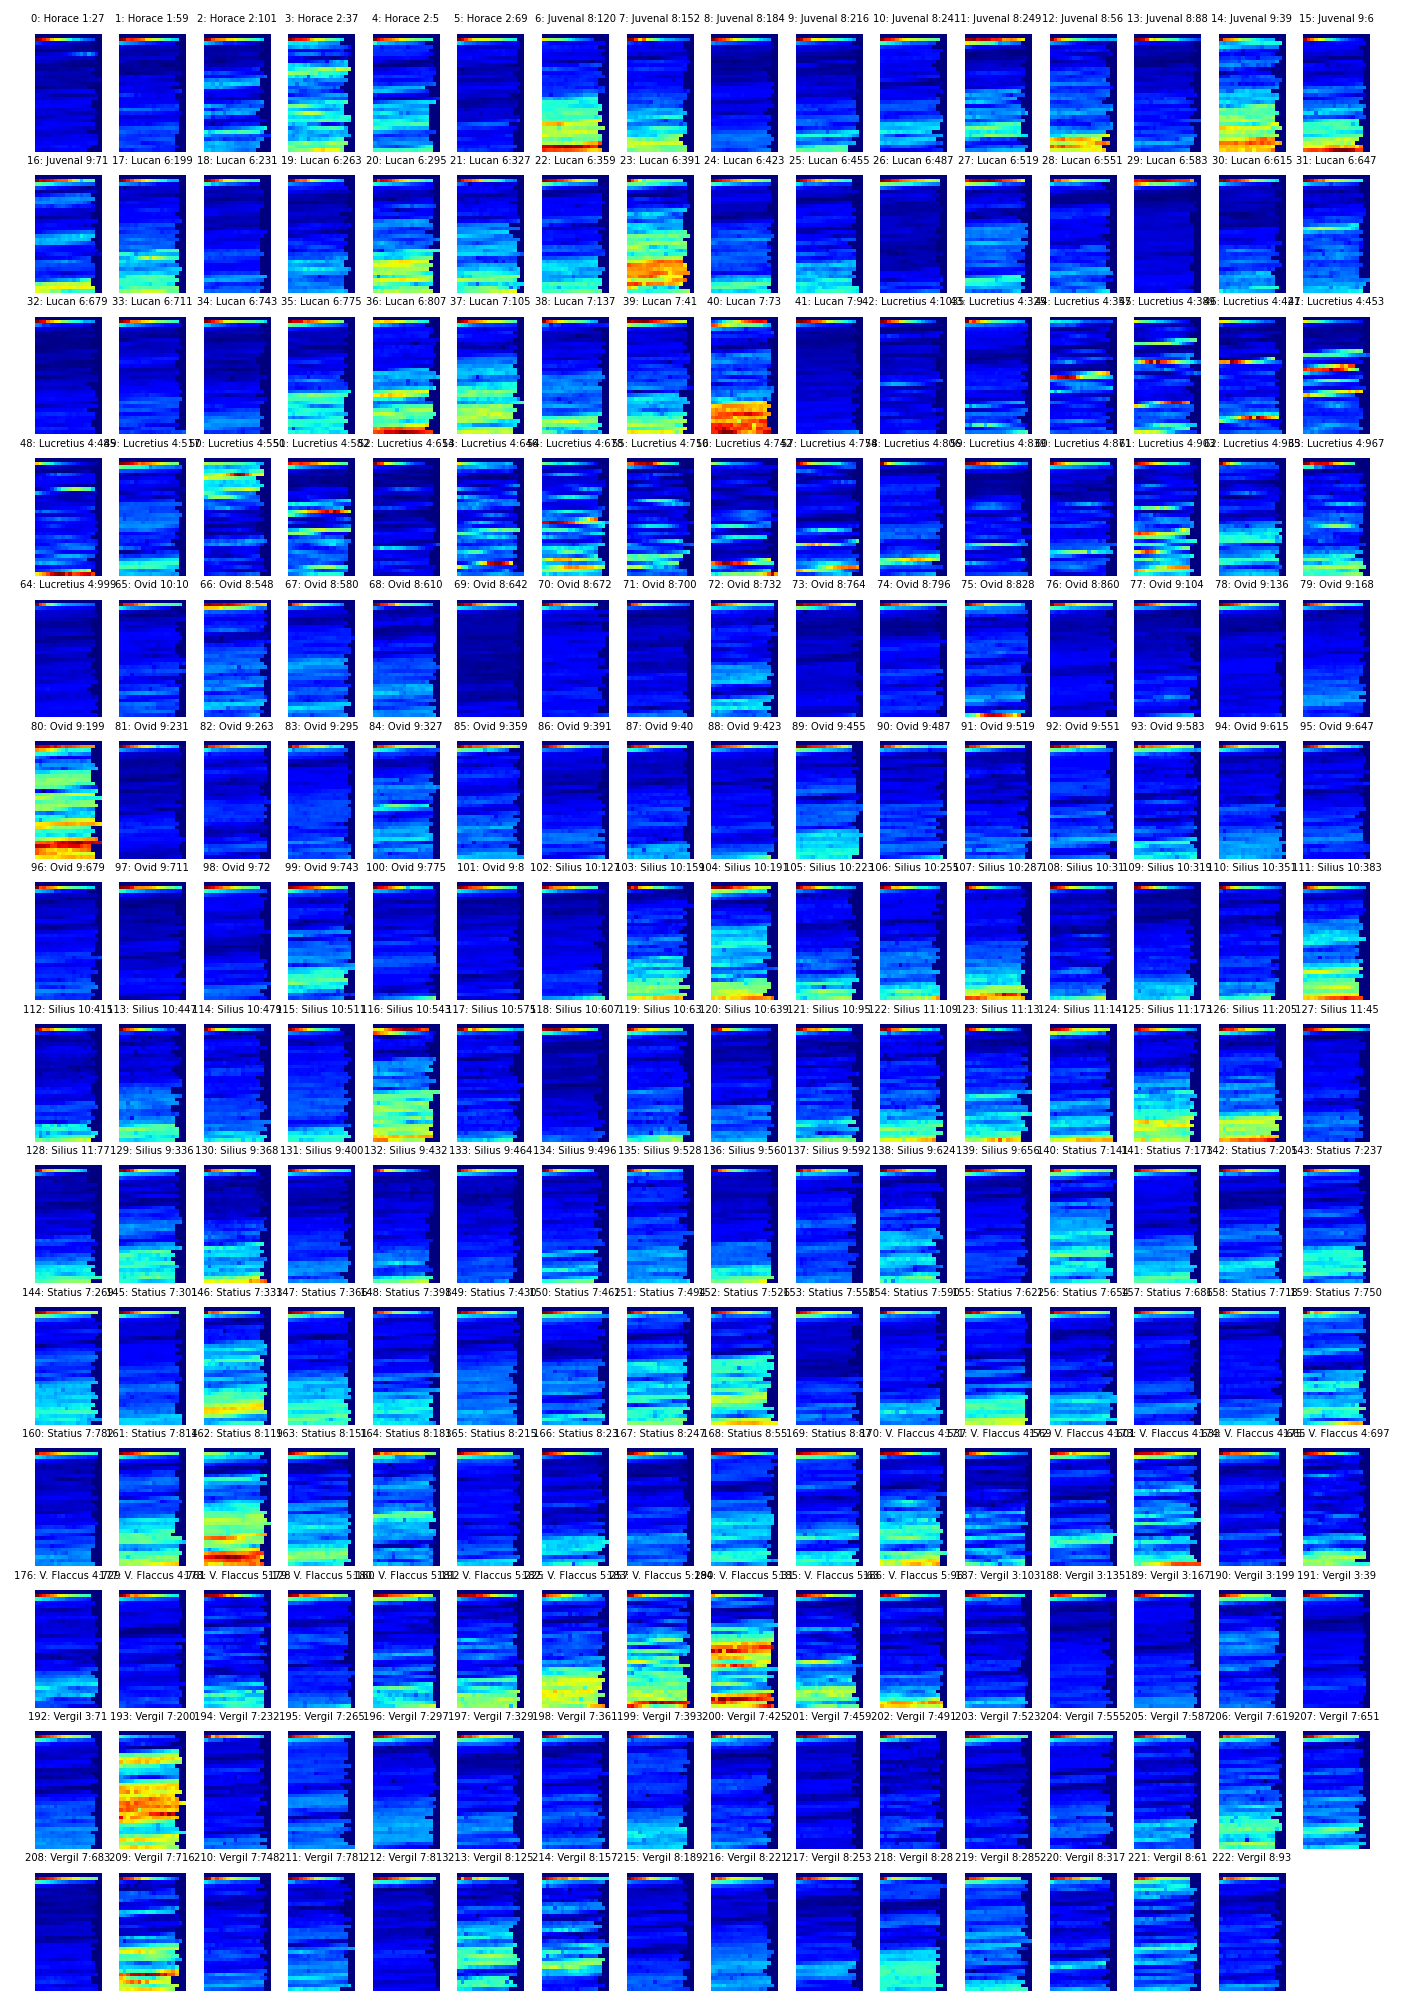

In [58]:
attention.draw_thumbnails(vs_lstm, titles_lstm, h=18, show_idx=True)

# CNN Attention Thumbs

2022-12-02 16:55:53.135328: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 857210880 exceeds 10% of free system memory.
2022-12-02 16:55:53.615240: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 857210880 exceeds 10% of free system memory.


164/164 [==============================] - 1s 6ms/step


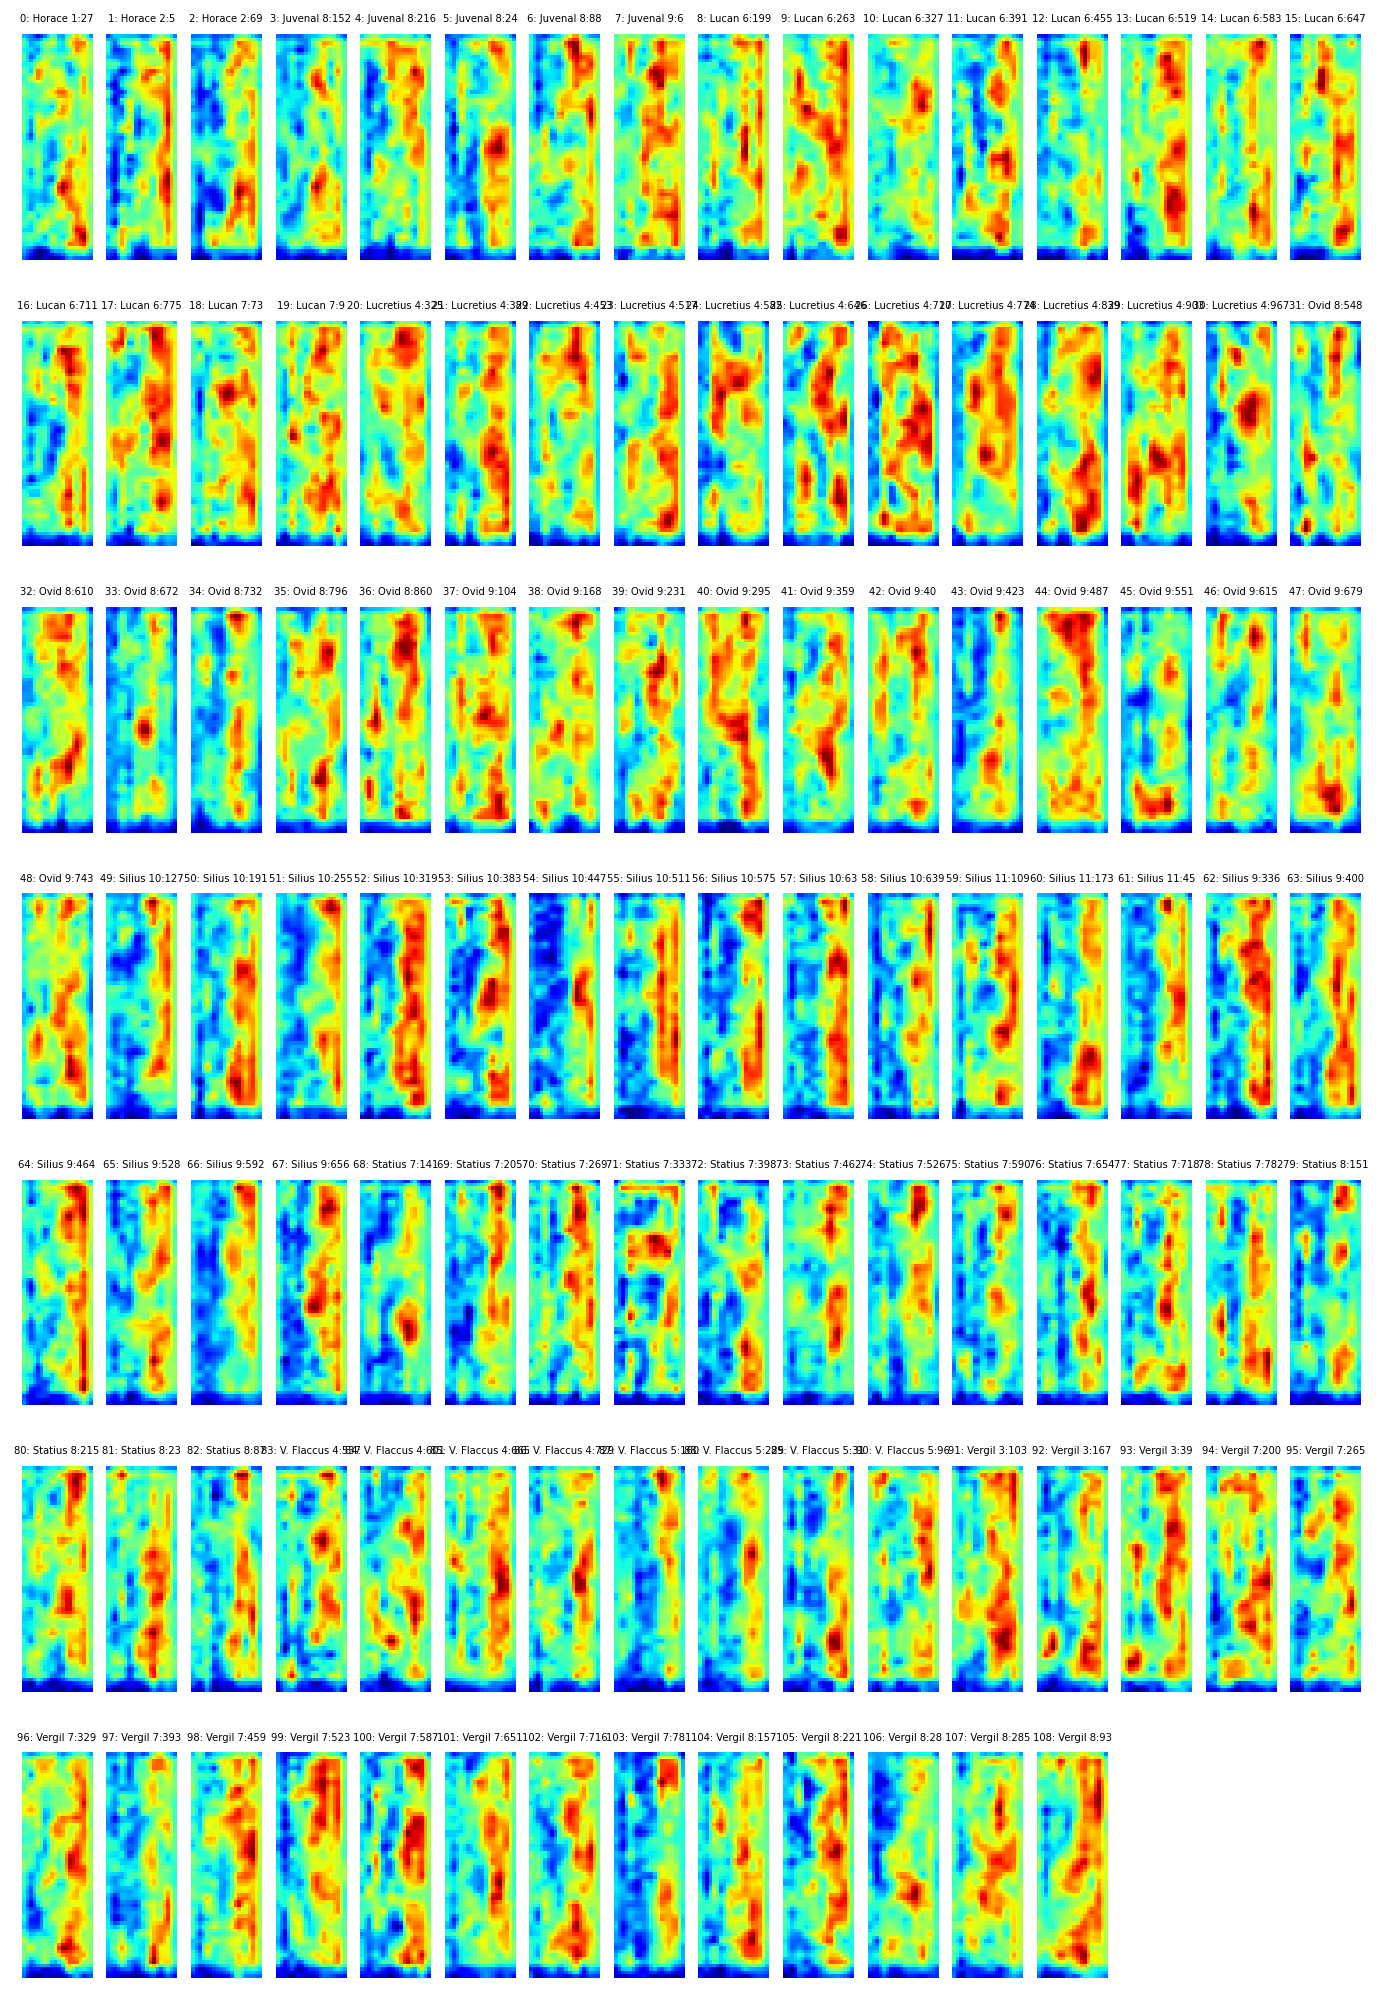

In [59]:
X_cnn, y_cnn, titles_cnn = prep_for_cnn(chunks_64, cnn_embedder, encoder)
sc_64 = scorecam(cnn_strip, X_cnn, y_cnn)
attention.draw_thumbnails(sc_64, titles_cnn, show_idx=True, h=18)

# Detailed Attention Maps

Basically we can now pick any index from the thumbnails that interests us and see the "big version"

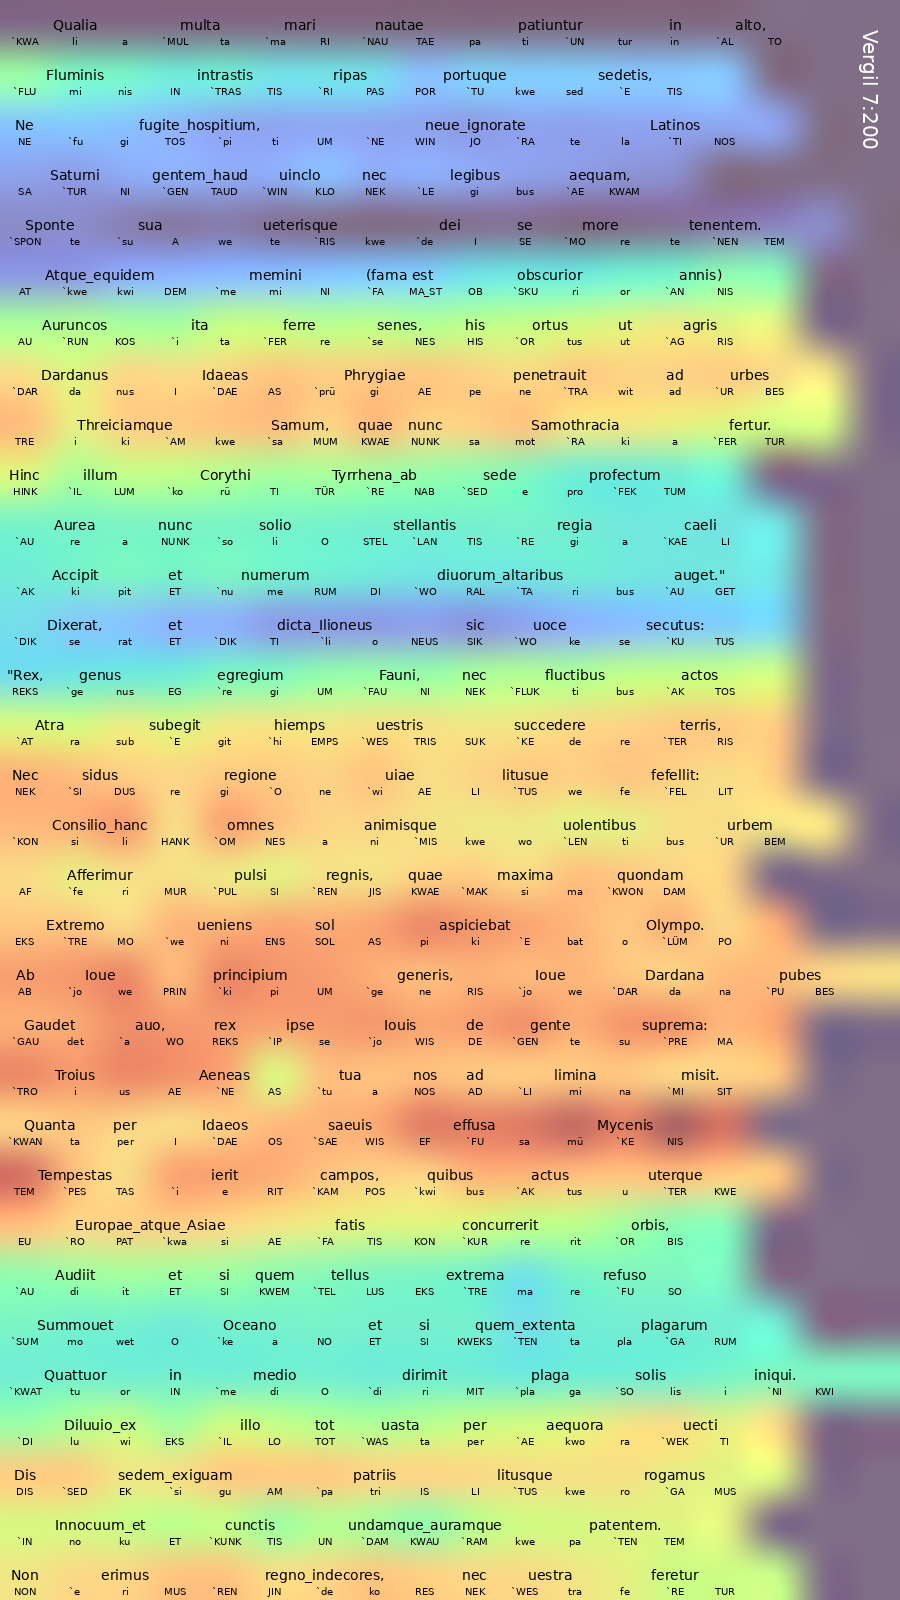

In [60]:
im = attention.attention_single(
    vs_lstm,
    list(chunks_32.Raw),
    list(titles_lstm),
    193,
    cmap='turbo',
    alpha=156,
    sampling=Image.Resampling.BICUBIC,
    # fn='aen_7200.png'
)
display(im)

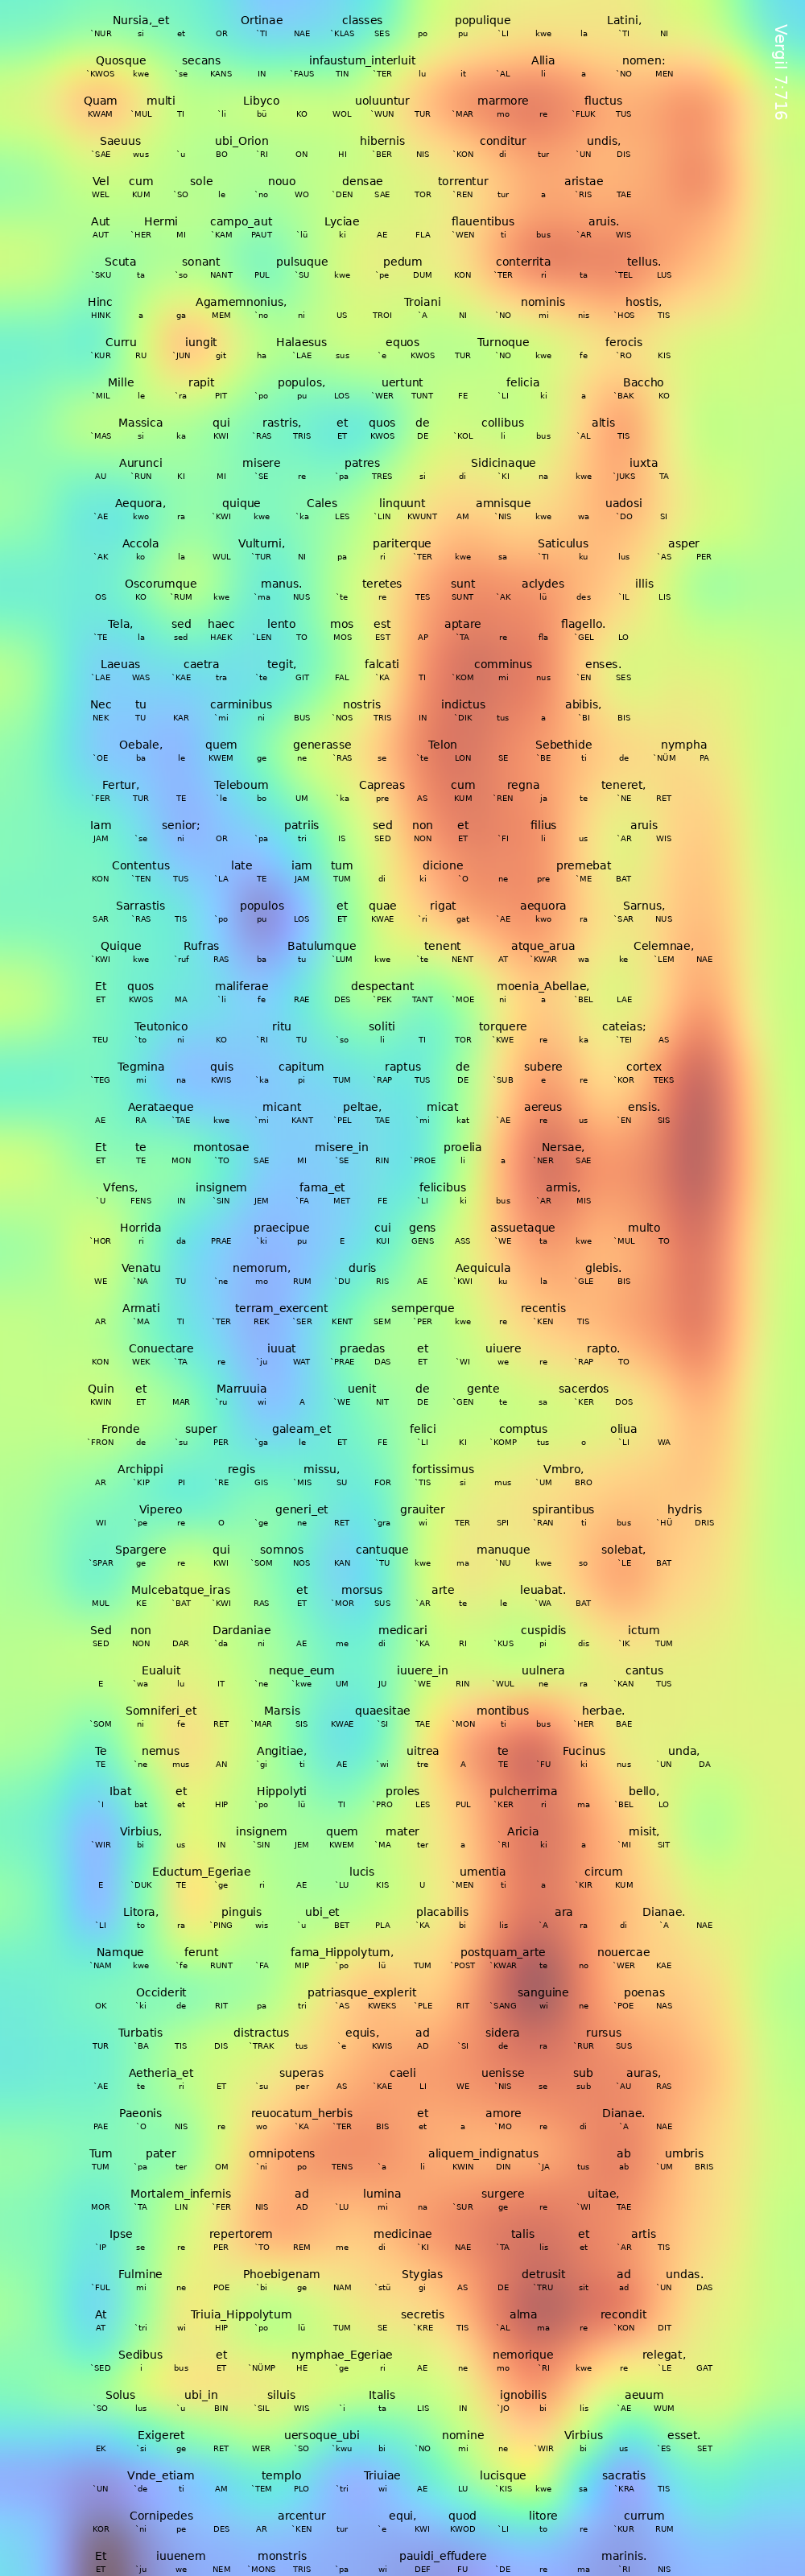

In [61]:
im = attention.attention_single(sc_64, list(chunks_64.Raw), titles_cnn, 102, cmap='turbo', alpha=156)
display(im)